
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Kikuchi Lines

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_10-Kikuchi_Lines.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_10-Kikuchi_Lines.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Load relevant python packages
### Check Installed Packages

In [ ]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.1.9':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
some libraries from the book
* kinematic scattering library.

In [5]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all notebook
    
# 3D plotting package used
from mpl_toolkits.mplot3d import Axes3D # 3D plotting 

# additional package 
import itertools 
import scipy.constants as const

# Import libraries from the pyTEMlib
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book
__notebook_version__ = '2021.02.11'

print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.02.09
notebook version:  2021.02.11



## Define  crystal


In [6]:
### Please choose another crystal like: Silicon, Aluminium, GaAs , ZnO
tags = ks.structure_by_name('silicon')

## Plot the unit cell

<IPython.core.display.Javascript object>


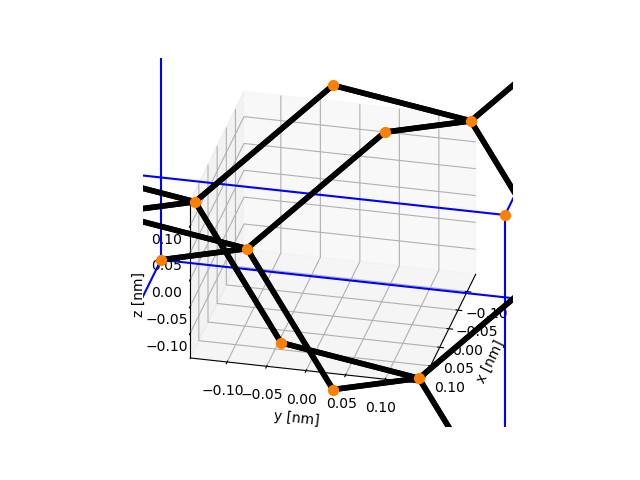

In [7]:
## Just to be sure the crystal structure is right
ks.plot_unitcell(tags)


## Parameters for Diffraction Calculation

Please note that we are using a rather small number of reflections: the maximum number of hkl is 1

In [8]:
tags['acceleration_voltage_V'] = 20.0 *1000.0 #V

tags['convergence_angle_mrad'] = 0

tags['zone_hkl'] = np.array([0,1,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([0,0,0])  # mistilt in degrees

tags['Sg_max'] = .5 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 1   # Highest evaluated Miller indices


## Kinematic Scattering Calculation

In [10]:
ks.kinematic_scattering(tags, False)
print(tags['hkl_max'])

1


## Plot Selected Area Electron Diffraction Pattern

<IPython.core.display.Javascript object>


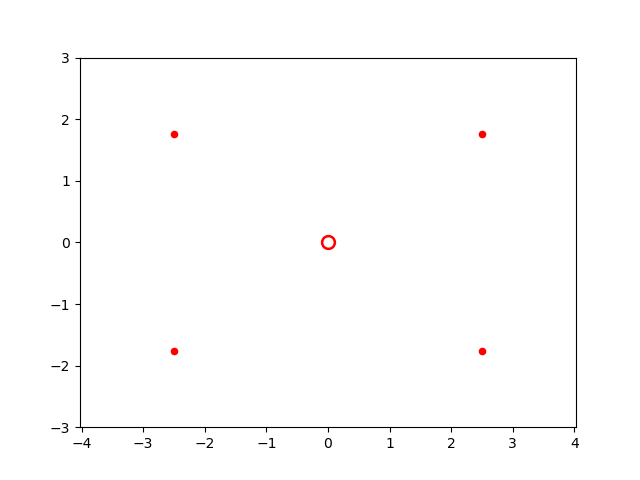

In [11]:
#####################
# Plot ZOLZ SAED Pattern #
#####################

# Get information from dictionary
# Get information from dictionary

#We plot only the allowed diffraction spots
points = tags['allowed']['g']
# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20)

# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.axis('equal')
FOV = 3
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

## Kikuchi Line Construction
The Kikuchi lines are the Bisections of lines from the center spot to the Bragg spots.

The line equation for a bisection of a line between two points $(A(x_A,y_A), B(x_B,y_B))$ is  given by the formula:

$y=-\frac{x_A-x_B}{y_A-y_B}x+\frac{x_A^2-x_B^2+y_A^2-y_B^2}{2 \cdot(y_A-y_B)}$

If $y_A = y_B$, then x is constant at $x= \frac{1}{2} (x_A+x_B)$

In our case  point $B$ is $(0,0)$ and so above equation is:

$y=-\frac{x_A}{y_A}x+\frac{x_A^2+y_A^2}{2 y_A}$ 

If $y_A$ is zero, the line is horizontal and $ x$ is constant at $x= \frac{1}{2} x_A$.

([-3, 3], [6.889047180788267, -1.5962341934503046])


<IPython.core.display.Javascript object>


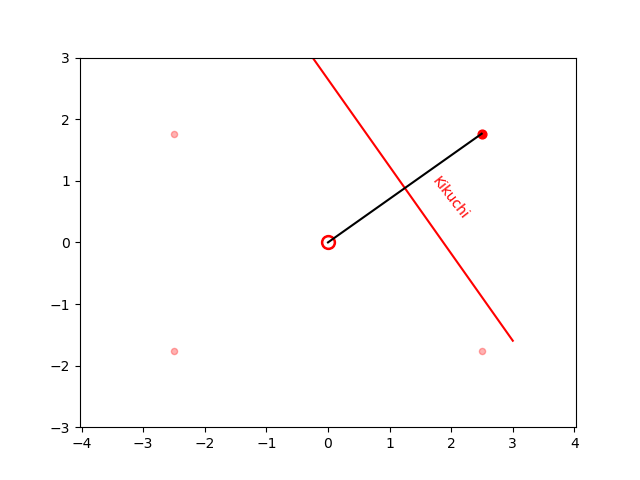

In [12]:
pointsZ = points[ZOLZ]

g = pointsZ[1,0:2]

x_A, y_A = g


slope = -x_A/y_A
y_0 = (x_A**2+ y_A**2)/(2*y_A)

# Starting point of Kikuchi Line
x1 = -FOV
y1 = y_0+slope*x1
# End point of Kikuchi Line
x2= FOV
y2 = y_0+slope*x2


print(([x1,x2],[y1,y2]))
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 , alpha = .3)
ax.scatter(g[0], g[1], c='red', s=40)
# Draw kikuchi
ax.plot([x1,x2],[y1,y2],c='r')
ax.text(g[0]/2+0.4,g[1]/2-0.5, 'Kikuchi',color ='r', rotation=-52)
ax.plot([0,g[0]],[0,g[1]],c='black')

# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.axis('equal')
FOV = 3
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

-2.4950559699326007 1.7642709957793206
([-3, 3], [-1.5962341934503046, 6.889047180788267])


<IPython.core.display.Javascript object>


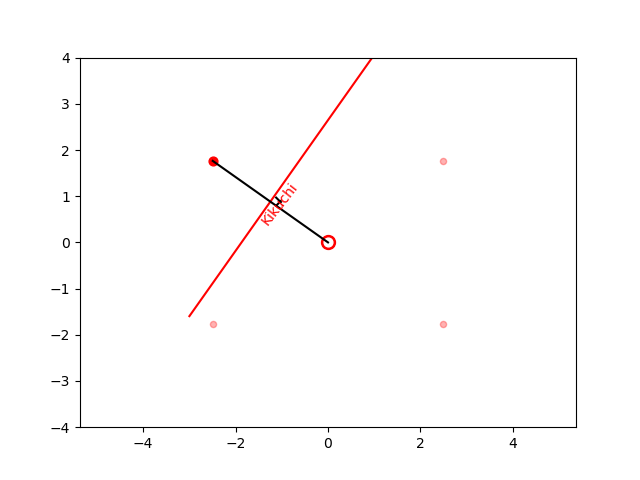

In [13]:
pointsZ = points[ZOLZ]

g = pointsZ[0,0:2]

x_A, y_A = g
print(x_A, y_A)
slope = -x_A/y_A
y_0 = (x_A**2+ y_A**2)/(2*y_A)

x1 = -FOV
y1 = y_0+slope*x1

x2= FOV
y2 = y_0+slope*x2


print(([x1,x2],[y1,y2]))
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 , alpha = .3)
ax.scatter(g[0], g[1], c='red', s=40)
ax.plot([x1,x2],[y1,y2],c='r')
ax.text(x1/2,g[1]/2-.5, 'Kikuchi',color ='r', rotation=52)
ax.plot([0,g[0]],[0,g[1]],c='black')

# Make right angle symbol
ax.plot([g[0]/2*.9,g[0]/2*.9+.1],[g[1]/2*.9,g[1]/2*.9+.1],c='black') 
ax.plot([g[0]/2*.9,g[0]/2*.9+.1],[g[1]/2*1.1,g[1]/2*1.1-.1],c='black') 

# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.axis('equal')
FOV = 4
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

## Plotting of Whole Kikuchi Pattern

<IPython.core.display.Javascript object>


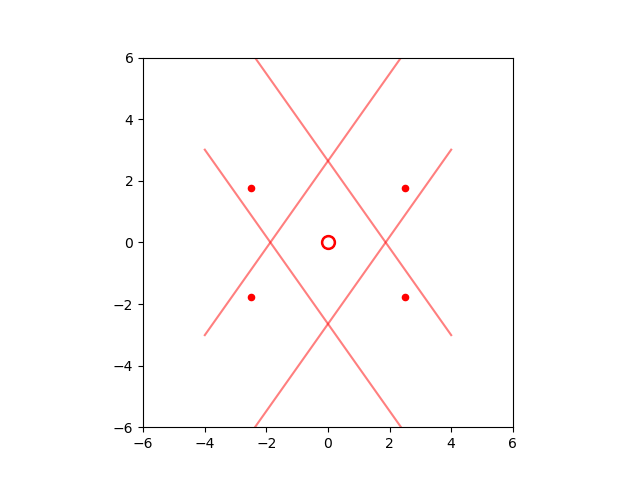

In [15]:
pointsZ = points[ZOLZ]

g = pointsZ[:,0:2]

FOV = 4
slope = -g[:,0]/g[:,1]
y_0 = (g[:,0]**2+ g[:,1]**2)/(2*g[:,1])

x1 = -FOV
y1 = y_0+slope*x1

x2= FOV
y2 = y_0+slope*x2


# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 )
ax.plot([x1,x2],[y1,y2],c='r', alpha = 0.5)




# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.set_aspect('equal')
FOV = 6
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

## Plotting of Whole Kikuchi Pattern
with a few more Bragg peaks, so plese increase **hkl_max** and see what happens!


<IPython.core.display.Javascript object>


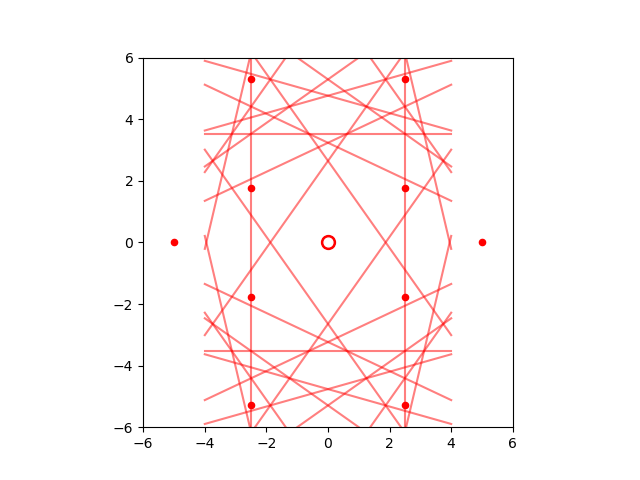

In [17]:
tags['hkl_max'] = 6
ks.kinematic_scattering(tags, False)
#We plot only the allowed diffraction spots
points = tags['allowed']['g']
# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']

pointsZ = points[ZOLZ]

g = pointsZ[:,0:2]

FOV = 4
slope = -g[:,0]/g[:,1]
y_0 = (g[:,0]**2+ g[:,1]**2)/(2*g[:,1])

x1 = -FOV
y1 = y_0+slope*x1

x2= FOV
y2 = y_0+slope*x2


# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 )
ax.plot([x1,x2],[y1,y2],c='r', alpha = 0.5)




# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.set_aspect('equal')
FOV = 6
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

## Plotting of Whole Kikuchi Pattern
with KinsCat Library

<IPython.core.display.Javascript object>


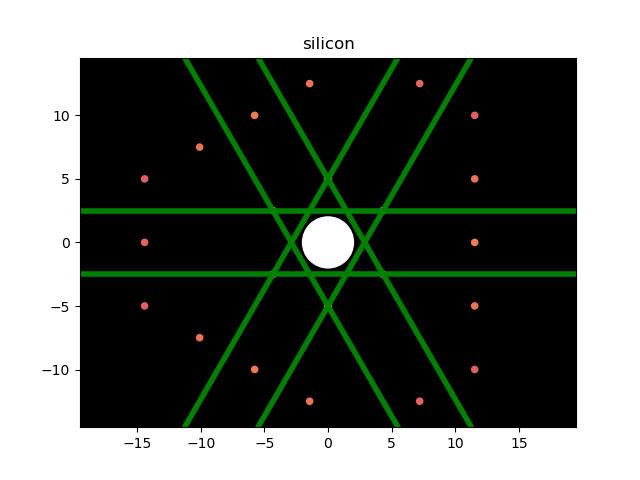

In [18]:
tags['Sg_max'] = .3 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 25   # Highest evaluated Miller indices
tags['zone_hkl'] = np.array([1,1,1])  
ks.kinematic_scattering(tags, False)
tags['plot FOV'] = 10
ks.plotKikuchi(tags)

## Conclusion
The Kikuchi lines are directly related to the Bragg reflections and therefore show the same symmetry as the diffraction pattern.


## Navigation

- <font size = "3">  **Back: [Unit Cel Determination](CH2_09-Unit_Cell.ipynb)** </font>
- <font size = "3">  **Next: [HOLZ Lines](CH2_11-HOLZ_Lines.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>